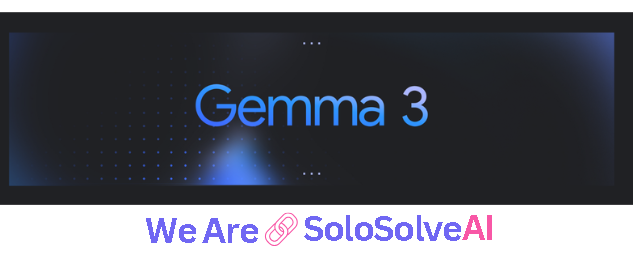

In [ ]:
# Cell 1: PyTorch and CUDA Version Check
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA not available. Training will run on CPU (very slow).")

PyTorch version: 2.7.1+cu126
CUDA available: True
CUDA version: 12.6
GPU Name: NVIDIA RTX A4000
GPU Memory: 15.72 GB


In [ ]:
# Cell 2: Installs (Corrected)
# Pinning transformers to a version known to work with Gemma 3.
# Added "deepspeed>=0.14.0" to resolve the ImportError with the Trainer.
!pip install -q "transformers==4.50.0" "datasets>=2.14.0" "peft>=0.7.0" "trl>=0.7.0" "accelerate>=0.25.0" "bitsandbytes>=0.41.3" "deepspeed>=0.14.0" sentencepiece huggingface_hub scikit-learn pandas matplotlib seaborn evaluate rouge_score

In [ ]:
# Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
import os

# --- Hugging Face Login ---
# It's better to store the token as an environment variable or use notebook_login() for interactive login.
# For non-interactive environments, ensure the token is securely managed.
# hf_token_value = "YOUR_HF_TOKEN_HERE" # Replace with your token or set as environment variable
hf_token_value = "_"# Example: Read from env var

if hf_token_value:
    try:
        login(token=hf_token_value)
        print("Hugging Face login successful (using provided token).")
    except Exception as e:
        print(f"Hugging Face login failed with provided token: {e}.")
        print("Please ensure your Hugging Face token is correct and has 'write' permissions if you plan to push models.")
        print("You can login manually using `from huggingface_hub import notebook_login; notebook_login()` in a new cell.")
else:
    print("Hugging Face token not provided. Login manually if needed for private models or pushing to hub.")
    # from huggingface_hub import notebook_login
    # notebook_login()

Hugging Face login successful (using provided token).


In [ ]:
# Cell 4: Imports and Main Configuration (Corrected)
import torch
from packaging.version import parse

# --- Environment Sanity Check ---
# This check ensures the correct version of PyTorch is loaded after installation.
# The new transformers library requires PyTorch >= 2.2. If this check fails,
# it means you need to restart the kernel.
if parse(torch.__version__) < parse("2.2.0"):
    raise ImportError(
        f"Your loaded PyTorch version is {torch.__version__}, but transformers==4.50.0 requires a version >= 2.2.0.\n\n"
        "SOLUTION: Please restart your notebook kernel/runtime now. In the menu, this is typically under 'Kernel' -> 'Restart' or 'Runtime' -> 'Restart session'. "
        "After restarting, run all cells from the beginning."
    )

# --- Original Imports (now safe to run) ---
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoModelForCausalLM, AutoTokenizer, AutoConfig, BitsAndBytesConfig,
    TrainingArguments, Trainer, DataCollatorForLanguageModeling,
    logging as hf_logging
)
from datasets import load_dataset, Dataset, concatenate_datasets
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import os
import json
import gc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Dict, List, Optional, Union
import re
from tqdm.auto import tqdm
import traceback
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate as hf_evaluate

# --- Configuration & Paths ---
NOTEBOOK_DIR = "/notebooks"
if not os.path.exists(NOTEBOOK_DIR):
    print(f"Directory {NOTEBOOK_DIR} does not exist. Creating it or use a local path.")
    NOTEBOOK_DIR = "."
    os.makedirs(NOTEBOOK_DIR, exist_ok=True)

SFT_DATASET_PATH = "/notebooks/amazon_fashion_sft_data_raft_final_v5.jsonl_checkpoint.jsonl"
STUDENT_MODEL_ID = "google/gemma-3-4b-it"

FINE_TUNED_MODEL_DIR_BASE = os.path.join(NOTEBOOK_DIR, "gemma-3-4b-fashion-multitask_A4000")
run_version = 1
while os.path.exists(f"{FINE_TUNED_MODEL_DIR_BASE}_v{run_version}"):
    run_version += 1
FINE_TUNED_MODEL_DIR = f"{FINE_TUNED_MODEL_DIR_BASE}_v{run_version}"

LORA_ADAPTER_DIR = os.path.join(FINE_TUNED_MODEL_DIR, "lora_adapter")
CLASSIFICATION_HEADS_PATH = os.path.join(FINE_TUNED_MODEL_DIR, "classification_heads.pth")
TOKENIZER_SAVE_PATH = os.path.join(FINE_TUNED_MODEL_DIR, "tokenizer")
OUTPUT_DIR_TRAINER_LOGS = os.path.join(FINE_TUNED_MODEL_DIR, "trainer_output_logs")
EVAL_RESULTS_DIR = os.path.join(FINE_TUNED_MODEL_DIR, "evaluation_results")

for path in [FINE_TUNED_MODEL_DIR, LORA_ADAPTER_DIR, TOKENIZER_SAVE_PATH, OUTPUT_DIR_TRAINER_LOGS, EVAL_RESULTS_DIR]:
    os.makedirs(path, exist_ok=True)

print(f"SFT Data Path: {SFT_DATASET_PATH}")
print(f"Student Model ID: {STUDENT_MODEL_ID}")
print(f"Artifacts will be saved to: {FINE_TUNED_MODEL_DIR}")

# --- Fine-Tuning Hyperparameters ---
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
LORA_TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
NUM_TRAIN_EPOCHS = 1
PER_DEVICE_TRAIN_BATCH_SIZE = 1
GRADIENT_ACCUMULATION_STEPS = 8
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
MAX_GRAD_NORM = 0.3
WARMUP_RATIO = 0.03
LR_SCHEDULER_TYPE = "cosine"
OPTIM = "paged_adamw_8bit"
LOGGING_STEPS = 10
SAVE_STRATEGY = "epoch"
PER_DEVICE_EVAL_BATCH_SIZE = PER_DEVICE_TRAIN_BATCH_SIZE

USE_4BIT_QUANTIZATION = True
USE_NESTED_QUANTIZATION = False
BNB_4BIT_COMPUTE_DTYPE = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float16
GRADIENT_CHECKPOINTING = True
GC_KWARGS = {"use_reentrant": False}

MAX_SEQ_LENGTH_TRAINING = 2048
SEED = 42
ATTN_IMPL_TRAINING = 'eager'

# --- Core Lists & Label Mappings (including new sentiment/aggression) ---
COMPLAINT_CATEGORIES = ["Sizing Issue", "Damaged Item", "Not as Described", "Shipping Problem", "Policy Inquiry", "Late Delivery", "Wrong Item Received", "Quality Issue", "Return Process Issue", "Other", "N/A"]
DECISION_TYPES = ["Full_Refund_No_Return", "Full_Refund_With_Return", "Partial_Refund_No_Return", "Partial_Refund_With_Return", "Exchange_Offered", "Deny_Request_Policy_Violation", "Further_Information_Required", "Escalate_To_Human_Agent", "Provide_Policy_Information", "Other", "N/A"]
EMOTIONAL_TONES_FOR_FORMAL_ANSWER = ["Empathetic_Standard", "Neutral_Direct", "Understanding_Apologetic", "Firm_Polite", "Helpful_Informative", "Other", "N/A"]
SUGGESTED_REFUND_PERCENTAGE_VALUES = sorted(list(set(map(int,[0, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 100]))))

SENTIMENT_CATEGORIES = ["positive", "neutral", "negative", "mixed", "very_negative", "N/A"]
AGGRESSION_LEVELS = ["none", "low", "medium", "high", "N/A"]

ACTIONABLE_MAP = {True: 1, False: 0, "true": 1, "false": 0, "True": 1, "False": 0}
COMPLAINT_CATEGORY_MAP = {cat: i for i, cat in enumerate(COMPLAINT_CATEGORIES)}
DECISION_TYPE_MAP = {dec: i for i, dec in enumerate(DECISION_TYPES)}
INFO_COMPLETE_MAP = {True: 1, False: 0, "true": 1, "false": 0, "True": 1, "False": 0}
EMOTIONAL_TONE_MAP = {tone: i for i, tone in enumerate(EMOTIONAL_TONES_FOR_FORMAL_ANSWER)}
REFUND_PERCENTAGE_MAP = {pct: i for i, pct in enumerate(SUGGESTED_REFUND_PERCENTAGE_VALUES)}
SENTIMENT_MAP = {cat: i for i, cat in enumerate(SENTIMENT_CATEGORIES)}
AGGRESSION_MAP = {level: i for i, level in enumerate(AGGRESSION_LEVELS)}

num_labels_dict_global = {
    "is_actionable": 2,
    "complaint_category": len(COMPLAINT_CATEGORY_MAP),
    "decision_recommendation": len(DECISION_TYPE_MAP),
    "info_complete": 2,
    "tone": len(EMOTIONAL_TONE_MAP),
    "refund_percentage": len(REFUND_PERCENTAGE_MAP),
    "sentiment": len(SENTIMENT_MAP),
    "aggression": len(AGGRESSION_MAP)
}
print(f"Number of classes for heads: {num_labels_dict_global}")

LOG_LEVEL = hf_logging.INFO
hf_logging.set_verbosity(LOG_LEVEL)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {DEVICE}")

if not os.path.exists(SFT_DATASET_PATH):
    print(f"SFT dataset not found at {SFT_DATASET_PATH}. Creating a dummy dataset for demonstration.")
    dummy_data = []
    for i in range(100):
        dummy_entry = {
            "id": f"dummy_{i}",
            "input_prompt_for_gemma3": f"Customer complaint {i}: The item arrived broken and I am very unhappy. User Profile: New user. Relevant Policies: Returns are accepted within 30 days. Other Policies: Shipping is free over $50. Product: T-shirt.",
            "gemini_json_output": json.dumps({
                "is_actionable_complaint": True if i % 2 == 0 else False,
                "complaint_category": COMPLAINT_CATEGORIES[i % len(COMPLAINT_CATEGORIES)],
                "decision_recommendation": DECISION_TYPES[i % len(DECISION_TYPES)],
                "information_completeness_assessment": {"is_complete": True if i % 3 == 0 else False},
                "formal_answer_to_customer": f"We are sorry to hear that. [TONE: {EMOTIONAL_TONES_FOR_FORMAL_ANSWER[i % len(EMOTIONAL_TONES_FOR_FORMAL_ANSWER)]}]",
                "suggested_refund_percentage": SUGGESTED_REFUND_PERCENTAGE_VALUES[i % len(SUGGESTED_REFUND_PERCENTAGE_VALUES)],
                "detected_customer_sentiment": SENTIMENT_CATEGORIES[i % len(SENTIMENT_CATEGORIES)],
                "detected_aggressiveness_level": AGRESSION_LEVELS[i % len(AGGRESSION_LEVELS)]
            })
        }
        dummy_data.append(dummy_entry)
    with open(SFT_DATASET_PATH, 'w') as f:
        for entry in dummy_data:
            f.write(json.dumps(entry) + '\\n')
    print(f"Dummy SFT dataset with {len(dummy_data)} entries created at {SFT_DATASET_PATH}")

/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-06-15 16:58:46.660317: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 16:58:46.660427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 16:58:46.742428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:

SFT Data Path: /notebooks/amazon_fashion_sft_data_raft_final_v5.jsonl_checkpoint.jsonl
Student Model ID: google/gemma-3-4b-it
Artifacts will be saved to: /notebooks/gemma-3-4b-fashion-multitask_A4000_v1
Number of classes for heads: {'is_actionable': 2, 'complaint_category': 11, 'decision_recommendation': 11, 'info_complete': 2, 'tone': 7, 'refund_percentage': 13, 'sentiment': 6, 'aggression': 5}
Training on: cuda


In [ ]:
# Cell 5: Custom Multi-Task Model Class (GemmaComplaintResolver) - CORRECTED
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
from typing import Dict, List, Optional, Union

class GemmaComplaintResolver(nn.Module):
    def __init__(self, base_model_name_or_path, num_labels_dict, model_config_for_base_loading, dropout_rate=0.1):
        super().__init__()
        bnb_config_runtime = None
        torch_dtype_runtime = None

        # --- MODIFICATION FOR ROBUST LOADING ---
        # Using device_map="auto" is the most robust way to handle model loading,
        # especially with quantization. It prevents memory spikes that can crash the kernel.
        device_map_param = "auto"
        # --- END OF MODIFICATION ---

        global USE_4BIT_QUANTIZATION, USE_NESTED_QUANTIZATION, BNB_4BIT_COMPUTE_DTYPE, DEVICE
        global ATTN_IMPL_TRAINING, GRADIENT_CHECKPOINTING, GC_KWARGS, num_labels_dict_global

        if USE_4BIT_QUANTIZATION:
            bnb_config_runtime = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_use_double_quant=USE_NESTED_QUANTIZATION,
                bnb_4bit_compute_dtype=BNB_4BIT_COMPUTE_DTYPE,
            )
            torch_dtype_runtime = None # Handled by BitsAndBytesConfig
            print(f"GCR: QLoRA enabled. Using device_map='{device_map_param}' and compute_dtype={BNB_4BIT_COMPUTE_DTYPE}")
        elif torch.cuda.is_available():
            if torch.cuda.is_bf16_supported():
                torch_dtype_runtime = torch.bfloat16
            else:
                torch_dtype_runtime = torch.float16
            print(f"GCR: No QLoRA. Using torch_dtype: {torch_dtype_runtime} with device_map='{device_map_param}'.")
        else:
            torch_dtype_runtime = torch.float32
            print(f"GCR: No QLoRA. Using float32 on CPU with device_map='{device_map_param}'.")

        actual_model_config = model_config_for_base_loading.text_config if hasattr(model_config_for_base_loading, 'text_config') and model_config_for_base_loading.text_config is not None else model_config_for_base_loading

        self.base_model = AutoModelForCausalLM.from_pretrained(
            base_model_name_or_path,
            config=actual_model_config,
            quantization_config=bnb_config_runtime,
            torch_dtype=torch_dtype_runtime,
            attn_implementation=ATTN_IMPL_TRAINING,
            trust_remote_code=True,
            device_map=device_map_param  # Use the robust "auto" setting
        )

        if not USE_4BIT_QUANTIZATION and GRADIENT_CHECKPOINTING:
            if hasattr(self.base_model, "gradient_checkpointing_enable"):
                self.base_model.gradient_checkpointing_enable(**GC_KWARGS)
                if hasattr(self.base_model.config, "use_cache"):
                    self.base_model.config.use_cache = False
                print("GCR: Gradient Checkpointing enabled on non-quantized base_model (in __init__).")

        if hasattr(self.base_model.config, 'hidden_size'):
             hidden_size = self.base_model.config.hidden_size
        else:
            temp_config = AutoConfig.from_pretrained(base_model_name_or_path, trust_remote_code=True)
            actual_temp_config = temp_config.text_config if hasattr(temp_config, 'text_config') and temp_config.text_config is not None else temp_config
            if hasattr(actual_temp_config, 'hidden_size'):
                hidden_size = actual_temp_config.hidden_size
            else:
                raise ValueError("Could not determine hidden_size from model config or fallback.")

        print(f"GCR: Base model loaded. Hidden_size: {hidden_size}")

        self.dropout = nn.Dropout(dropout_rate)
        # Add new heads for sentiment and aggression
        self.head_is_actionable = nn.Linear(hidden_size, num_labels_dict_global["is_actionable"])
        self.head_complaint_category = nn.Linear(hidden_size, num_labels_dict_global["complaint_category"])
        self.head_decision_recommendation = nn.Linear(hidden_size, num_labels_dict_global["decision_recommendation"])
        self.head_info_complete = nn.Linear(hidden_size, num_labels_dict_global["info_complete"])
        self.head_tone = nn.Linear(hidden_size, num_labels_dict_global["tone"])
        self.head_refund_percentage = nn.Linear(hidden_size, num_labels_dict_global["refund_percentage"])
        self.head_sentiment = nn.Linear(hidden_size, num_labels_dict_global["sentiment"])
        self.head_aggression = nn.Linear(hidden_size, num_labels_dict_global["aggression"])

        self.criterion_classification = nn.CrossEntropyLoss(ignore_index=-100)

    def gradient_checkpointing_enable(self, gradient_checkpointing_kwargs=None):
        if hasattr(self.base_model, "gradient_checkpointing_enable"):
            current_gc_kwargs = gradient_checkpointing_kwargs if gradient_checkpointing_kwargs else GC_KWARGS
            self.base_model.gradient_checkpointing_enable(gradient_checkpointing_kwargs=current_gc_kwargs)
            print(f"GCR.gradient_checkpointing_enable() called and forwarded to self.base_model with kwargs: {current_gc_kwargs}.")
            if hasattr(self.base_model.config, "use_cache"):
                self.base_model.config.use_cache = False
                print("GCR: Set self.base_model.config.use_cache = False due to GC enable.")

    def gradient_checkpointing_disable(self):
        if hasattr(self.base_model, "gradient_checkpointing_disable"):
            self.base_model.gradient_checkpointing_disable()
            print("GCR.gradient_checkpointing_disable() called and forwarded to self.base_model.")
            if hasattr(self.base_model.config, "use_cache"):
                 self.base_model.config.use_cache = True
                 print("GCR: Set self.base_model.config.use_cache = True after GC disable.")

    def prepare_inputs_for_generation(self, *args, **kwargs):
        return self.base_model.prepare_inputs_for_generation(*args, **kwargs)

    @property
    def config(self):
        return self.base_model.config

    @property
    def device(self):
        try:
            return next(self.base_model.parameters()).device
        except StopIteration:
            try:
                return next(self.head_is_actionable.parameters()).device
            except StopIteration:
                return torch.device("cpu")

    def forward(self, input_ids, attention_mask=None, labels=None,
                label_is_actionable=None, label_complaint_category=None,
                label_decision_recommendation=None, label_info_complete=None,
                label_tone=None, label_refund_percentage=None,
                label_sentiment=None, label_aggression=None, **kwargs):

        transformer_outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_hidden_states=True,
            return_dict=True
        )

        lm_loss = transformer_outputs.loss
        last_hidden_state = transformer_outputs.hidden_states[-1]

        if attention_mask is not None:
            sequence_lengths = attention_mask.sum(dim=1) - 1
            sequence_lengths = torch.clamp(sequence_lengths, 0, last_hidden_state.size(1) - 1)
            pooled_output = last_hidden_state[torch.arange(last_hidden_state.size(0), device=last_hidden_state.device), sequence_lengths]
        else:
            pooled_output = last_hidden_state[:, -1, :]

        pooled_output = self.dropout(pooled_output)

        logits_is_actionable = self.head_is_actionable(pooled_output)
        logits_complaint_category = self.head_complaint_category(pooled_output)
        logits_decision_recommendation = self.head_decision_recommendation(pooled_output)
        logits_info_complete = self.head_info_complete(pooled_output)
        logits_tone = self.head_tone(pooled_output)
        logits_refund_percentage = self.head_refund_percentage(pooled_output)
        logits_sentiment = self.head_sentiment(pooled_output)
        logits_aggression = self.head_aggression(pooled_output)

        total_loss = torch.tensor(0.0, device=input_ids.device)

        if lm_loss is not None and not torch.isnan(lm_loss):
            total_loss += lm_loss
        elif lm_loss is not None and torch.isnan(lm_loss):
            print(f"Warning: LM loss is NaN.")

        classification_losses_dict = {}

        def _add_cls_loss(loss_name, logits, target_labels):
            nonlocal total_loss
            if target_labels is not None:
                target_labels = target_labels.to(logits.device)
                if not torch.all(target_labels == -100):
                    cls_loss = self.criterion_classification(logits.view(-1, logits.size(-1)), target_labels.view(-1))
                    if not torch.isnan(cls_loss):
                        total_loss += cls_loss
                        classification_losses_dict[loss_name] = cls_loss.item()
                    else:
                        classification_losses_dict[loss_name] = "nan"
                else:
                    classification_losses_dict[loss_name] = "skipped"

        _add_cls_loss('loss_actionable', logits_is_actionable, label_is_actionable)
        _add_cls_loss('loss_category', logits_complaint_category, label_complaint_category)
        _add_cls_loss('loss_decision', logits_decision_recommendation, label_decision_recommendation)
        _add_cls_loss('loss_info_complete', logits_info_complete, label_info_complete)
        _add_cls_loss('loss_tone', logits_tone, label_tone)
        _add_cls_loss('loss_refund', logits_refund_percentage, label_refund_percentage)
        _add_cls_loss('loss_sentiment', logits_sentiment, label_sentiment)
        _add_cls_loss('loss_aggression', logits_aggression, label_aggression)

        outputs = {
            "loss": total_loss,
            "lm_loss": lm_loss.item() if lm_loss is not None and not torch.isnan(lm_loss) else (float('nan') if lm_loss is not None else None),
            "classification_losses": classification_losses_dict,
            "logits": transformer_outputs.logits,
            "logits_is_actionable": logits_is_actionable,
            "logits_complaint_category": logits_complaint_category,
            "logits_decision_recommendation": logits_decision_recommendation,
            "logits_info_complete": logits_info_complete,
            "logits_tone": logits_tone,
            "logits_refund_percentage": logits_refund_percentage,
            "logits_sentiment": logits_sentiment,
            "logits_aggression": logits_aggression
        }

        return outputs

print("GemmaComplaintResolver class defined with corrected device_map handling.")

GemmaComplaintResolver class defined with corrected device_map handling.


In [ ]:
# Cell 6: Load and Prepare SFT Dataset
# Ensure global variables from Cell 4 are accessible if this cell is run separately
# global MAX_SEQ_LENGTH_TRAINING, SEED, STUDENT_MODEL_ID, SFT_DATASET_PATH
# global ACTIONABLE_MAP, COMPLAINT_CATEGORY_MAP, DECISION_TYPE_MAP, INFO_COMPLETE_MAP
# global EMOTIONAL_TONE_MAP, REFUND_PERCENTAGE_MAP, SENTIMENT_MAP, AGGRESSION_MAP, num_labels_dict_global
# global tokenizer, model_config_for_tokens # Tokenizer is set here

# Imports that might be needed if Cell 4 didn't fully execute or if running standalone (already in Cell 4 though)
# import os
# import json
# import pandas as pd
# import re
# from tqdm.auto import tqdm
# import traceback
# from datasets import Dataset
# from transformers import AutoTokenizer, AutoConfig

tokenizer = None # Initialize to be safe
processed_train_dataset = None
processed_eval_dataset = None
model_config_for_tokens = None # Initialize

try:
    if not os.path.exists(SFT_DATASET_PATH): # SFT_DATASET_PATH from Cell 4
        raise FileNotFoundError(f"SFT dataset file not found: {SFT_DATASET_PATH}. Please ensure it's created or path is correct.")

    sft_data_list = []
    with open(SFT_DATASET_PATH, 'r') as f:
        for line_num, line in enumerate(f):
            try:
                sft_data_list.append(json.loads(line))
            except json.JSONDecodeError:
                print(f"Skipping malformed line {line_num+1} in SFT data: {line[:100]}")

    if not sft_data_list:
        raise ValueError("SFT dataset is empty or all lines were malformed.")

    raw_sft_dataset_full = Dataset.from_list(sft_data_list)

    print(f"Loaded {len(raw_sft_dataset_full)} raw SFT entries.")

    # SEED from Cell 4
    if len(raw_sft_dataset_full) > 10:
        dataset_split = raw_sft_dataset_full.train_test_split(test_size=0.1, seed=SEED, shuffle=True)
        train_dataset_raw = dataset_split["train"]
        eval_dataset_raw = dataset_split["test"]
    else:
        train_dataset_raw = raw_sft_dataset_full
        eval_dataset_raw = None
        print("Dataset too small for a train/eval split. Using all data for training.")

    print(f"Raw train samples: {len(train_dataset_raw)}, Raw eval samples: {len(eval_dataset_raw) if eval_dataset_raw else 0}")

    print(f"Loading Tokenizer: {STUDENT_MODEL_ID}") # STUDENT_MODEL_ID from Cell 4
    tokenizer = AutoTokenizer.from_pretrained(STUDENT_MODEL_ID, trust_remote_code=True)
    model_config_for_tokens = AutoConfig.from_pretrained(STUDENT_MODEL_ID, trust_remote_code=True)

    if tokenizer.bos_token_id is None:
        tokenizer.bos_token_id = getattr(model_config_for_tokens, 'bos_token_id', 2)
    tokenizer.bos_token = tokenizer.decode([tokenizer.bos_token_id]) if tokenizer.bos_token_id is not None else "<bos>"

    eos_token_id_from_config = getattr(model_config_for_tokens, 'eos_token_id', 1)
    if isinstance(eos_token_id_from_config, list): tokenizer.eos_token_id = eos_token_id_from_config[0]
    else: tokenizer.eos_token_id = eos_token_id_from_config
    tokenizer.eos_token = tokenizer.decode([tokenizer.eos_token_id]) if tokenizer.eos_token_id is not None else "<eos>"

    if tokenizer.pad_token_id is None or tokenizer.pad_token_id == tokenizer.eos_token_id:
        config_pad_id = getattr(model_config_for_tokens, 'pad_token_id', 0)
        if config_pad_id is not None and config_pad_id != tokenizer.eos_token_id: tokenizer.pad_token_id = config_pad_id
        else: tokenizer.pad_token_id = 0

        pad_token_str = tokenizer.decode([tokenizer.pad_token_id])
        if pad_token_str and pad_token_str.strip() and pad_token_str != tokenizer.eos_token and pad_token_str != tokenizer.bos_token :
            tokenizer.pad_token = pad_token_str
        else:
            tokenizer.pad_token = "<pad>"
            if tokenizer.pad_token not in tokenizer.get_vocab() or tokenizer.convert_tokens_to_ids(tokenizer.pad_token) != tokenizer.pad_token_id :
                 if tokenizer.pad_token_id == 0 and tokenizer.decode([0]).strip() == "":
                     if "<pad>" not in tokenizer.get_vocab(): tokenizer.add_special_tokens({'pad_token': "<pad>"})
                     tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids("<pad>")
                 elif "<pad>" not in tokenizer.get_vocab():
                      tokenizer.add_special_tokens({'pad_token': tokenizer.pad_token})
                      tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

    tokenizer.padding_side = "right"
    print(f"Tokenizer: BOS ID: {tokenizer.bos_token_id} ('{tokenizer.bos_token}'), PAD ID: {tokenizer.pad_token_id} ('{tokenizer.pad_token}'), EOS ID: {tokenizer.eos_token_id} ('{tokenizer.eos_token}'), Side: {tokenizer.padding_side}")

    if tokenizer.pad_token_id == tokenizer.eos_token_id and tokenizer.pad_token_id is not None:
        if tokenizer.eos_token_id == 0 and tokenizer.pad_token_id == 0:
            tokenizer.eos_token_id = 1; tokenizer.eos_token = "<eos>"
            tokenizer.pad_token_id = 0; tokenizer.pad_token = "<pad>"
        if tokenizer.pad_token_id == tokenizer.eos_token_id: raise ValueError("PAD and EOS token IDs are still the same.")
    if tokenizer.pad_token_id == tokenizer.bos_token_id and tokenizer.pad_token_id is not None:
        raise ValueError(f"PAD ID ({tokenizer.pad_token_id}) and BOS ID ({tokenizer.bos_token_id}) are the same.")

except Exception as e:
    print(f"Error in data loading or tokenizer setup: {e}")
    traceback.print_exc()
    raise RuntimeError("Failed to load data or tokenizer.") from e

debug_example_counter = 0

def process_sft_example_multitask(example: Dict):
    global tokenizer, MAX_SEQ_LENGTH_TRAINING, debug_example_counter
    # MAX_SEQ_LENGTH_TRAINING, ACTIONABLE_MAP etc. are from Cell 4
    if tokenizer is None: return None

    # MODIFIED to get 'input_prompt_for_gemma3'
    input_prompt_for_gemma3 = example.get('input_prompt_for_gemma3', '') # Key change here
    gemini_output_raw = example.get('gemini_json_output')

    if not input_prompt_for_gemma3 or not gemini_output_raw:
        tqdm.write(f"Skipping example due to missing prompt or output. ID: {example.get('id', 'NO_ID')}")
        return None

    try:
        gemini_output_data = json.loads(gemini_output_raw) if isinstance(gemini_output_raw, str) else gemini_output_raw
        if not isinstance(gemini_output_data, dict):
            tqdm.write(f"Skipping example due to non-dict JSON output. ID: {example.get('id', 'NO_ID')}")
            return None
    except (json.JSONDecodeError, TypeError) as e:
        tqdm.write(f"Skipping example due to JSON parsing error: {e}. ID: {example.get('id', 'NO_ID')}. Raw: {str(gemini_output_raw)[:100]}")
        return None

    student_input_text_content = str(input_prompt_for_gemma3).strip()
    student_input_text_for_masking = f"<start_of_turn>user\\n{student_input_text_content}<end_of_turn>\\n<start_of_turn>model\\n"
    target_json_string = json.dumps(gemini_output_data, ensure_ascii=False)
    full_sequence_for_lm = student_input_text_for_masking + target_json_string + tokenizer.eos_token

    tokenized_prompt_part_for_length = tokenizer(student_input_text_for_masking, add_special_tokens=False, return_attention_mask=False)
    prompt_length_in_tokens = len(tokenized_prompt_part_for_length['input_ids'])

    if debug_example_counter < 5: # Debug prints from original notebook
        tokenized_response_part = tokenizer(target_json_string + tokenizer.eos_token, add_special_tokens=False)
        response_length_in_tokens = len(tokenized_response_part['input_ids'])
        total_conceptual_length = prompt_length_in_tokens + response_length_in_tokens
        temp_full_tokenized = tokenizer(full_sequence_for_lm, add_special_tokens=True)
        bos_added_in_full = 1 if temp_full_tokenized['input_ids'][0] == tokenizer.bos_token_id else 0
        print(f"\\n--- Debug Example ID: {example.get('id', 'NO_ID')} (Counter: {debug_example_counter}) ---")
        print(f"MAX_SEQ_LENGTH_TRAINING: {MAX_SEQ_LENGTH_TRAINING}")
        print(f"1. student_input_text_for_masking (first 50 chars): '{student_input_text_for_masking[:50]}...'\n   Tokenized length (prompt_length_in_tokens): {prompt_length_in_tokens}")
        print(f"2. target_json_string + eos_token (first 50 chars): '{(target_json_string + tokenizer.eos_token)[:50]}...'\n   Tokenized length (response_length_in_tokens): {response_length_in_tokens}")
        print(f"3. Conceptual total length (prompt + response before BOS consideration): {total_conceptual_length}")
        print(f"   Conceptual total length if BOS is added to full seq: {bos_added_in_full + total_conceptual_length}")
        print(f"   Is (BOS + total_conceptual_length) > MAX_SEQ_LENGTH_TRAINING? {(bos_added_in_full + total_conceptual_length) > MAX_SEQ_LENGTH_TRAINING}")
        debug_example_counter += 1

    labels_dict = {}
    ignore_val = -100
    try: # Label extraction logic from original notebook, including new fields
        is_act_val = gemini_output_data.get('is_actionable_complaint')
        labels_dict['label_is_actionable'] = ACTIONABLE_MAP.get(is_act_val, ACTIONABLE_MAP.get(str(is_act_val).lower() if pd.notna(is_act_val) else None, ignore_val))
        cat_val = gemini_output_data.get('complaint_category')
        labels_dict['label_complaint_category'] = COMPLAINT_CATEGORY_MAP.get(cat_val, ignore_val)
        dec_val = gemini_output_data.get('decision_recommendation')
        labels_dict['label_decision_recommendation'] = DECISION_TYPE_MAP.get(dec_val, ignore_val)
        info_comp_dict = gemini_output_data.get('information_completeness_assessment', {})
        is_comp_val = info_comp_dict.get('is_complete') if isinstance(info_comp_dict, dict) else None
        labels_dict['label_info_complete'] = INFO_COMPLETE_MAP.get(is_comp_val, INFO_COMPLETE_MAP.get(str(is_comp_val).lower() if pd.notna(is_comp_val) else None, ignore_val))
        formal_ans_val = gemini_output_data.get('formal_answer_to_customer', '')
        tone_match = re.search(r"\\[TONE:\\s*(.*?)\\s*\\]", str(formal_ans_val))
        tone_str_val = tone_match.group(1).strip() if tone_match else None
        labels_dict['label_tone'] = EMOTIONAL_TONE_MAP.get(tone_str_val, ignore_val)
        refund_pct_val = gemini_output_data.get('suggested_refund_percentage')
        refund_pct_int = ignore_val
        if pd.notna(refund_pct_val):
            try: refund_pct_int = int(float(refund_pct_val))
            except (ValueError, TypeError): refund_pct_int = ignore_val
        labels_dict['label_refund_percentage'] = REFUND_PERCENTAGE_MAP.get(refund_pct_int, ignore_val)
        sent_val = gemini_output_data.get('detected_customer_sentiment') # NEW
        labels_dict['label_sentiment'] = SENTIMENT_MAP.get(sent_val, ignore_val) # NEW
        aggr_val = gemini_output_data.get('detected_aggressiveness_level') # NEW
        labels_dict['label_aggression'] = AGGRESSION_MAP.get(aggr_val, ignore_val) # NEW
    except Exception as e:
        tqdm.write(f"Label extraction error for ID {example.get('id', 'NO_ID_LABEL_EXTRACT')}: {e}. Output data: {str(gemini_output_data)[:100]}")
        for key_name in num_labels_dict_global.keys(): labels_dict[f'label_{key_name}'] = ignore_val

    current_id = example.get('id', f"missing_id_{os.urandom(4).hex()}")
    return {"text_for_lm": full_sequence_for_lm, "prompt_length_for_masking": prompt_length_in_tokens, "id": current_id, **labels_dict}

if train_dataset_raw and tokenizer: # train_dataset_raw from earlier in this cell
    print("Processing training data for multi-task...")
    debug_example_counter = 0
    columns_to_keep = ["id", "text_for_lm", "prompt_length_for_masking"] + [f"label_{k}" for k in num_labels_dict_global.keys()]
    columns_to_remove_train = [col for col in train_dataset_raw.column_names if col not in columns_to_keep]
    processed_train_dataset = train_dataset_raw.map(process_sft_example_multitask, load_from_cache_file=False, remove_columns=columns_to_remove_train).filter(lambda x: x is not None and "prompt_length_for_masking" in x)
    print(f"Processed train dataset: {len(processed_train_dataset)} samples. Columns: {processed_train_dataset.column_names}")

    if eval_dataset_raw and len(eval_dataset_raw) > 0: # eval_dataset_raw from earlier
        print("Processing evaluation data for multi-task...")
        debug_example_counter = 0
        columns_to_remove_eval = [col for col in eval_dataset_raw.column_names if col not in columns_to_keep]
        processed_eval_dataset = eval_dataset_raw.map(process_sft_example_multitask, load_from_cache_file=False, remove_columns=columns_to_remove_eval).filter(lambda x: x is not None and "prompt_length_for_masking" in x)
        print(f"Processed eval dataset: {len(processed_eval_dataset)} samples. Columns: {processed_eval_dataset.column_names}")
    else:
        processed_eval_dataset = None
        print("No evaluation data to process or eval_dataset_raw is empty.")
else:
    print("Skipping data processing: missing raw training data or tokenizer.")

Loaded 240 raw SFT entries.
Raw train samples: 216, Raw eval samples: 24
Loading Tokenizer: google/gemma-3-4b-it


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer.json
loading file added_tokens.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/added_tokens.json
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/tokenizer_config.json
loading file chat_template.jinja from cache at None


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/config.json
text_config is None, using default Gemma3TextConfig vision config.
vision_config is None or incompatible with Gemma3VisionConfig intialization. Gemma3 will be limited to text tasks.
Model config Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "boi_token_index": 255999,
  "eoi_token_index": 256000,
  "eos_token_id": [
    1,
    106
  ],
  "image_token_index": 262144,
  "initializer_range": 0.02,
  "mm_tokens_per_image": 256,
  "model_type": "gemma3",
  "text_config": {
    "attention_bias": false,
    "attention_dropout": 0.0,
    "attn_logit_softcapping": null,
    "cache_implementation": "hybrid",
    "final_logit_softcapping": null,
    "head_dim": 256,
    "hidden_activation": "gelu_pytorch_tanh",
    "hidden_size": 2560,
    "initializer_range": 0.02,
    "intermediate_size": 1

Tokenizer: BOS ID: 2 ('<bos>'), PAD ID: 0 ('<pad>'), EOS ID: 1 ('<eos>'), Side: right
Processing training data for multi-task...


Map:   0%|          | 0/216 [00:00<?, ? examples/s]

\n--- Debug Example ID: sft_raft_sample_177_AFMVS2HYISB7FAAXT3WUB3JNN4VQ (Counter: 0) ---
MAX_SEQ_LENGTH_TRAINING: 2048
1. student_input_text_for_masking (first 50 chars): '<start_of_turn>user\nCustomer Complaint:
Title: Ch...'
   Tokenized length (prompt_length_in_tokens): 389
2. target_json_string + eos_token (first 50 chars): '{"complaint_category": "Quality Issue", "complaint...'
   Tokenized length (response_length_in_tokens): 374
3. Conceptual total length (prompt + response before BOS consideration): 763
   Conceptual total length if BOS is added to full seq: 764
   Is (BOS + total_conceptual_length) > MAX_SEQ_LENGTH_TRAINING? False
\n--- Debug Example ID: sft_raft_sample_151_AFP6VCELJ4DV7OXCVRQT5IJFMAFA (Counter: 1) ---
MAX_SEQ_LENGTH_TRAINING: 2048
1. student_input_text_for_masking (first 50 chars): '<start_of_turn>user\nCustomer Complaint:
Title: Th...'
   Tokenized length (prompt_length_in_tokens): 417
2. target_json_string + eos_token (first 50 chars): '{"complaint_category

Filter:   0%|          | 0/216 [00:00<?, ? examples/s]

Processed train dataset: 216 samples. Columns: ['id', 'text_for_lm', 'prompt_length_for_masking', 'label_is_actionable', 'label_complaint_category', 'label_decision_recommendation', 'label_info_complete', 'label_tone', 'label_refund_percentage', 'label_sentiment', 'label_aggression']
Processing evaluation data for multi-task...


Map:   0%|          | 0/24 [00:00<?, ? examples/s]

\n--- Debug Example ID: sft_raft_sample_235_AEFIYB7CCG454XTF6YY5ATT5NZEQ (Counter: 0) ---
MAX_SEQ_LENGTH_TRAINING: 2048
1. student_input_text_for_masking (first 50 chars): '<start_of_turn>user\nCustomer Complaint:
Title: No...'
   Tokenized length (prompt_length_in_tokens): 397
2. target_json_string + eos_token (first 50 chars): '{"complaint_category": "Quality Issue", "complaint...'
   Tokenized length (response_length_in_tokens): 402
3. Conceptual total length (prompt + response before BOS consideration): 799
   Conceptual total length if BOS is added to full seq: 800
   Is (BOS + total_conceptual_length) > MAX_SEQ_LENGTH_TRAINING? False
\n--- Debug Example ID: sft_raft_sample_107_AGODY2UON4QW2MLUR25B4IAVBRLQ (Counter: 1) ---
MAX_SEQ_LENGTH_TRAINING: 2048
1. student_input_text_for_masking (first 50 chars): '<start_of_turn>user\nCustomer Complaint:
Title: Be...'
   Tokenized length (prompt_length_in_tokens): 834
2. target_json_string + eos_token (first 50 chars): '{"complaint_category

Filter:   0%|          | 0/24 [00:00<?, ? examples/s]

Processed eval dataset: 24 samples. Columns: ['id', 'text_for_lm', 'prompt_length_for_masking', 'label_is_actionable', 'label_complaint_category', 'label_decision_recommendation', 'label_info_complete', 'label_tone', 'label_refund_percentage', 'label_sentiment', 'label_aggression']


In [ ]:
# Cell 7: Custom Data Collator
from transformers import DataCollatorForLanguageModeling
from typing import List, Dict
import torch

global MAX_SEQ_LENGTH_TRAINING # Ensure this is accessible

class MultiTaskDataCollator(DataCollatorForLanguageModeling):
    def __init__(self, tokenizer, mlm=False, max_length=None):
        super().__init__(tokenizer=tokenizer, mlm=mlm)

        global MAX_SEQ_LENGTH_TRAINING
        effective_max_length = tokenizer.model_max_length
        if hasattr(tokenizer, 'max_len_single_sentence') and tokenizer.max_len_single_sentence is not None:
             effective_max_length = min(effective_max_length, tokenizer.max_len_single_sentence)

        self.max_length = max_length if max_length is not None else effective_max_length
        cap_length = MAX_SEQ_LENGTH_TRAINING if 'MAX_SEQ_LENGTH_TRAINING' in globals() and MAX_SEQ_LENGTH_TRAINING is not None else 2048

        if self.max_length > cap_length :
            print(f"DataCollator: Initial max_length ({self.max_length}) > training_cap ({cap_length}). Capping to {cap_length}.")
            self.max_length = cap_length
        print(f"MultiTaskDataCollator initialized with max_length: {self.max_length}")
        self.debug_collator_counter = 0


    def __call__(self, examples: List[Dict]) -> Dict[str, torch.Tensor]:
        full_sequences = [ex["text_for_lm"] for ex in examples]
        prompt_lengths_for_masking = [ex["prompt_length_for_masking"] for ex in examples]

        batch_tokenized = self.tokenizer(
            full_sequences,
            padding="longest",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        batch = {
            "input_ids": batch_tokenized["input_ids"],
            "attention_mask": batch_tokenized["attention_mask"]
        }
        lm_labels = batch["input_ids"].clone()

        for i in range(len(examples)):
            example_id_for_debug = examples[i].get("id", f"unknown_id_idx_{i}")
            prompt_len_tokens_from_example = prompt_lengths_for_masking[i]
            actual_input_ids_for_example = batch_tokenized["input_ids"][i]
            batch_seq_len = lm_labels.size(1) # Max length in this specific batch after padding/truncation

            # Actual content length for this specific example in the batch (excluding padding)
            current_example_content_length = actual_input_ids_for_example.ne(self.tokenizer.pad_token_id).sum().item()

            initial_mask_end_idx = prompt_len_tokens_from_example
            final_mask_end_idx = initial_mask_end_idx # Start with this

            # Check if BOS token was prepended by the main tokenizer call
            bos_was_prepended = False
            if self.tokenizer.bos_token_id is not None and \
               actual_input_ids_for_example[0] == self.tokenizer.bos_token_id:
                bos_was_prepended = True
                final_mask_end_idx = 1 + prompt_len_tokens_from_example # Mask BOS + original prompt tokens

            # Ensure mask_end_idx does not exceed the actual content length of this example or the batch's max sequence length
            final_mask_end_idx = min(final_mask_end_idx, current_example_content_length)
            final_mask_end_idx = min(final_mask_end_idx, batch_seq_len) # Defensive

            if self.debug_collator_counter < 5 * len(examples) : # Print for first few batches
                print(f"\n--- Collator Debug for Example ID: {example_id_for_debug} (Batch item {i}, Global collator count: {self.debug_collator_counter}) ---")
                print(f"  Received prompt_length_from_example: {prompt_len_tokens_from_example}")
                print(f"  Batch max sequence_len (lm_labels.size(1)): {batch_seq_len}")
                print(f"  This example's actual content_length (no pad): {current_example_content_length}")
                print(f"  BOS token prepended by main tokenizer: {bos_was_prepended} (BOS ID: {self.tokenizer.bos_token_id}, First token: {actual_input_ids_for_example[0].item()})")
                print(f"  Mask end index before min ops (initial_mask_end_idx if no BOS, 1+initial if BOS): {1 + prompt_len_tokens_from_example if bos_was_prepended else prompt_len_tokens_from_example}")
                print(f"  Final mask_end_idx (after min with content_length & batch_seq_len): {final_mask_end_idx}")

                if final_mask_end_idx > 0:
                    masked_tokens_decoded = self.tokenizer.decode(actual_input_ids_for_example[:final_mask_end_idx], skip_special_tokens=False)
                    unmasked_tokens_decoded = self.tokenizer.decode(actual_input_ids_for_example[final_mask_end_idx:current_example_content_length], skip_special_tokens=False)
                    print(f"  Tokens to be masked (decoded, first 70 chars): '{masked_tokens_decoded[:70]}...'")
                    print(f"  Tokens to be UNMASKED (target, first 70 chars): '{unmasked_tokens_decoded[:70]}...'")
                else:
                    print(f"  No tokens will be masked for prompt (final_mask_end_idx is {final_mask_end_idx}).")

                if final_mask_end_idx >= current_example_content_length and current_example_content_length > 0 :
                     print(f"  CRITICAL_COLLATOR_DEBUG: final_mask_end_idx ({final_mask_end_idx}) >= current_example_content_length ({current_example_content_length}). All content tokens will be masked!")
                self.debug_collator_counter +=1

            if final_mask_end_idx > 0:
                lm_labels[i, :final_mask_end_idx] = -100
            elif prompt_len_tokens_from_example > 0: # If prompt had length but nothing is masked
                 if self.debug_collator_counter < 10 * len(examples): # Print for a bit longer if this happens
                    print(f"  Warning (DataCollator): Prompt length was {prompt_len_tokens_from_example} but final_mask_end_idx is {final_mask_end_idx} for example {example_id_for_debug}. No LM masking applied for prompt part.")


        if self.tokenizer.pad_token_id is not None:
            lm_labels[lm_labels == self.tokenizer.pad_token_id] = -100

        batch["labels"] = lm_labels

        if torch.all(lm_labels == -100) and lm_labels.numel() > 0 : # Check if not an empty tensor
            if self.debug_collator_counter < 10 * len(examples) or (self.debug_collator_counter % 100 ==0) : # Print more often if this persists
                print(f"Warning (DataCollator): All LM labels are -100 for this batch. Batch size: {len(examples)}. Example 0 input_ids (first 30): {batch['input_ids'][0, :30]}... Example 0 labels (first 30): {lm_labels[0, :30]}...")

        label_keys = [k for k in examples[0].keys() if k.startswith('label_')]
        for key in label_keys:
            label_values = [ex.get(key, -100) for ex in examples]
            try:
                batch[key] = torch.tensor(label_values, dtype=torch.long).to(batch['input_ids'].device)
            except Exception as e: # Simplified, original had more logging here
                print(f"Error converting labels for key {key} to tensor: {e}")
                batch[key] = torch.full((len(examples),), -100, dtype=torch.long).to(batch['input_ids'].device)
        return batch

print("MultiTaskDataCollator defined with extensive debugging prints.")

MultiTaskDataCollator defined with extensive debugging prints.


In [ ]:
# Cell 8: Model Instantiation & LoRA
model = None

if tokenizer and processed_train_dataset and len(processed_train_dataset) > 0 :
    try:
        print(f"Loading base model '{STUDENT_MODEL_ID}' for multi-task fine-tuning...")
        model_config_main = AutoConfig.from_pretrained(STUDENT_MODEL_ID, trust_remote_code=True)

        model_multitask = GemmaComplaintResolver(
            base_model_name_or_path=STUDENT_MODEL_ID,
            num_labels_dict=num_labels_dict_global,
            model_config_for_base_loading=model_config_main,
        )
        print("GemmaComplaintResolver instantiated.")

        if USE_4BIT_QUANTIZATION:
            print("Preparing base_model component for k-bit training...")
            # model_multitask.base_model is the AutoModelForCausalLM instance
            # prepare_model_for_kbit_training will enable GC on this if GRADIENT_CHECKPOINTING is True
            model_multitask.base_model = prepare_model_for_kbit_training(
                model_multitask.base_model,
                use_gradient_checkpointing=GRADIENT_CHECKPOINTING
            )
            print("Base model component prepared for k-bit training.")
            # prepare_model_for_kbit_training also sets use_cache=False if GC is enabled.
            if GRADIENT_CHECKPOINTING and hasattr(model_multitask.base_model.config, 'use_cache') and model_multitask.base_model.config.use_cache:
                 print("Warning: use_cache is True after prepare_model_for_kbit_training with GC. Forcing False.")
                 model_multitask.base_model.config.use_cache = False
            elif GRADIENT_CHECKPOINTING:
                 print("QLoRA with GC: use_cache should be False on base_model.config (handled by prepare_model_for_kbit_training).")


        if not USE_4BIT_QUANTIZATION and next(model_multitask.parameters()).device.type == 'cpu' and DEVICE.type == 'cuda':
             print(f"Moving model_multitask (non-QLoRA) to {DEVICE} before PEFT...")
             model_multitask = model_multitask.to(DEVICE)
             print(f"model_multitask is now on device: {next(model_multitask.parameters()).device}")

        lora_config_obj = LoraConfig(
            r=LORA_R,
            lora_alpha=LORA_ALPHA,
            target_modules=LORA_TARGET_MODULES,
            lora_dropout=LORA_DROPOUT,
            bias="none",
            task_type="CAUSAL_LM"
        )

        model = get_peft_model(model_multitask, lora_config_obj)
        print("LoRA applied to GemmaComplaintResolver.")
        model.print_trainable_parameters()

        if str(model.device) != str(DEVICE) and DEVICE.type == "cuda":
            print(f"Moving final PeftModel from {model.device} to {DEVICE}...")
            model = model.to(DEVICE)
        print(f"Full PeftModel is on device: {model.device}")

        if hasattr(model, 'base_model') and isinstance(model.base_model, GemmaComplaintResolver):
            resolver_instance_check = model.base_model
            for head_name_attr_check in num_labels_dict_global.keys():
                actual_head_attr = f"head_{head_name_attr_check}"
                if hasattr(resolver_instance_check, actual_head_attr):
                    head_module_check = getattr(resolver_instance_check, actual_head_attr)
                    try:
                        if next(head_module_check.parameters()).device != model.device:
                             head_module_check.to(model.device)
                        # print(f"Device of {actual_head_attr}: {next(head_module_check.parameters()).device}") # Less verbose
                    except StopIteration:
                        pass # print(f"Head {actual_head_attr} has no parameters.")
                # else:
                    # print(f"Head attribute '{actual_head_attr}' not found for device check.")

        if GRADIENT_CHECKPOINTING:
            underlying_hf_model = model.base_model.base_model
            if hasattr(underlying_hf_model.config, 'use_cache'):
                if not underlying_hf_model.config.use_cache:
                    print("GC is ON and use_cache is correctly False on underlying LLM config.")
                else:
                    print("Warning: GC is ON but use_cache is True on underlying LLM config. Forcing False.")
                    underlying_hf_model.config.use_cache = False
            else:
                print("Warning: Could not verify use_cache on underlying LLM config for GC.")

    except Exception as e:
        print(f"Error during model setup: {e}")
        traceback.print_exc()
        model = None
else:
    print("Skipping model setup: missing tokenizer or data, or processed_train_dataset is empty.")

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/config.json
text_config is None, using default Gemma3TextConfig vision config.
vision_config is None or incompatible with Gemma3VisionConfig intialization. Gemma3 will be limited to text tasks.
Model config Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "boi_token_index": 255999,
  "eoi_token_index": 256000,
  "eos_token_id": [
    1,
    106
  ],
  "image_token_index": 262144,
  "initializer_range": 0.02,
  "mm_tokens_per_image": 256,
  "model_type": "gemma3",
  "text_config": {
    "attention_bias": false,
    "attention_dropout": 0.0,
    "attn_logit_softcapping": null,
    "cache_implementation": "hybrid",
    "final_logit_softcapping": null,
    "head_dim": 256,
    "hidden_activation": "gelu_pytorch_tanh",
    "hidden_size": 2560,
    "initializer_range": 0.02,
    "intermediate_size": 1

Loading base model 'google/gemma-3-4b-it' for multi-task fine-tuning...
GCR: QLoRA enabled. Using device_map='auto' and compute_dtype=torch.bfloat16


Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in 8-bit or 4-bit. Pass your own torch_dtype to specify the dtype of the remaining non-linear layers or pass torch_dtype=torch.float16 to remove this warning.
loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/model.safetensors.index.json


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Instantiating Gemma3ForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "pad_token_id": 0
}

target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/gemma-3-4b-it were not used when initializing Gemma3ForCausalLM: ['multi_modal_projector.mm_input_projection_weight', 'multi_modal_projector.mm_soft_emb_norm.weight', 'vision_tower.vision_model.embeddings.patch_embedding.bias', 'vision_tower.vision_model.embeddings.patch_embedding.weight', 'vision_tower.vision_model.embeddings.position_embedding.weight', 'vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_tower.vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_tower.vision_model.encod

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "do_sample": true,
  "eos_token_id": [
    1,
    106
  ],
  "pad_token_id": 0,
  "top_k": 64,
  "top_p": 0.95
}



GCR: Base model loaded. Hidden_size: 2560
GemmaComplaintResolver instantiated.
Preparing base_model component for k-bit training...
Base model component prepared for k-bit training.
LoRA applied to GemmaComplaintResolver.
trainable params: 29,802,496 || all params: 3,910,211,641 || trainable%: 0.7622
Moving final PeftModel from cuda:0 to cuda...
Full PeftModel is on device: cuda:0
GC is ON and use_cache is correctly False on underlying LLM config.


PyTorch: setting up devices



--- Configuring and Starting Multi-Task Training ---
Label names for Trainer: ['label_aggression', 'label_complaint_category', 'label_decision_recommendation', 'label_info_complete', 'label_is_actionable', 'label_refund_percentage', 'label_sentiment', 'label_tone', 'labels']
MultiTaskDataCollator initialized with max_length: 2048
[2025-06-15 17:00:03,306] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/tmp/ipykernel_226/968156931.py:79: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


[2025-06-15 17:00:04,649] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


Using auto half precision backend


Trainer instantiated. Starting training...


***** Running training *****
  Num examples = 216
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 27
  Number of trainable parameters = 29,802,496


Starting trainer.train()...
GCR.gradient_checkpointing_enable() called and forwarded to self.base_model with kwargs: {'use_reentrant': False}.
GCR: Set self.base_model.config.use_cache = False due to GC enable.

--- Collator Debug for Example ID: sft_raft_sample_7_AFIBEDLW2PCNNRS6LTPNPSFZUMAQ (Batch item 0, Global collator count: 0) ---
  Received prompt_length_from_example: 408
  Batch max sequence_len (lm_labels.size(1)): 814
  This example's actual content_length (no pad): 814
  BOS token prepended by main tokenizer: True (BOS ID: 2, First token: 2)
  Mask end index before min ops (initial_mask_end_idx if no BOS, 1+initial if BOS): 409
  Final mask_end_idx (after min with content_length & batch_seq_len): 409
  Tokens to be masked (decoded, first 70 chars): '<bos><start_of_turn>user\nCustomer Complaint:
Title: Bad quality holes...'
  Tokens to be UNMASKED (target, first 70 chars): '{"complaint_category": "Damaged Item", "complaint_summary": "Customer ...'

--- Collator Debug for Exam

Epoch,Training Loss,Validation Loss
1,64.418600,6.885519



***** Running Evaluation *****
  Num examples = 24
  Batch size = 1
Saving model checkpoint to /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/trainer_output_logs/checkpoint-27
tokenizer config file saved in /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/trainer_output_logs/checkpoint-27/tokenizer_config.json
Special tokens file saved in /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/trainer_output_logs/checkpoint-27/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/trainer_output_logs/checkpoint-27 (score: 6.885519027709961).
Saving model checkpoint to /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/lora_adapter


Training finished.
***** train metrics *****
  epoch                    =        1.0
  total_flos               =        0GF
  train_loss               =    78.2644
  train_runtime            = 0:05:22.93
  train_samples_per_second =      0.669
  train_steps_per_second   =      0.084
Training metrics saved.


tokenizer config file saved in /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/lora_adapter/tokenizer_config.json
Special tokens file saved in /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/lora_adapter/special_tokens_map.json
tokenizer config file saved in /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/tokenizer/tokenizer_config.json
Special tokens file saved in /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/tokenizer/special_tokens_map.json


Best LoRA adapter saved to /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/lora_adapter
Saving classification head weights to /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/classification_heads.pth...
Classification head weights saved.
Saving Tokenizer to /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/tokenizer...
Tokenizer saved.

All artifacts for the best model are saved in /notebooks/gemma-3-4b-fashion-multitask_A4000_v1

--- Generating Training Visualizations ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Training graphs saved to: /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/evaluation_results/training_graphs.png


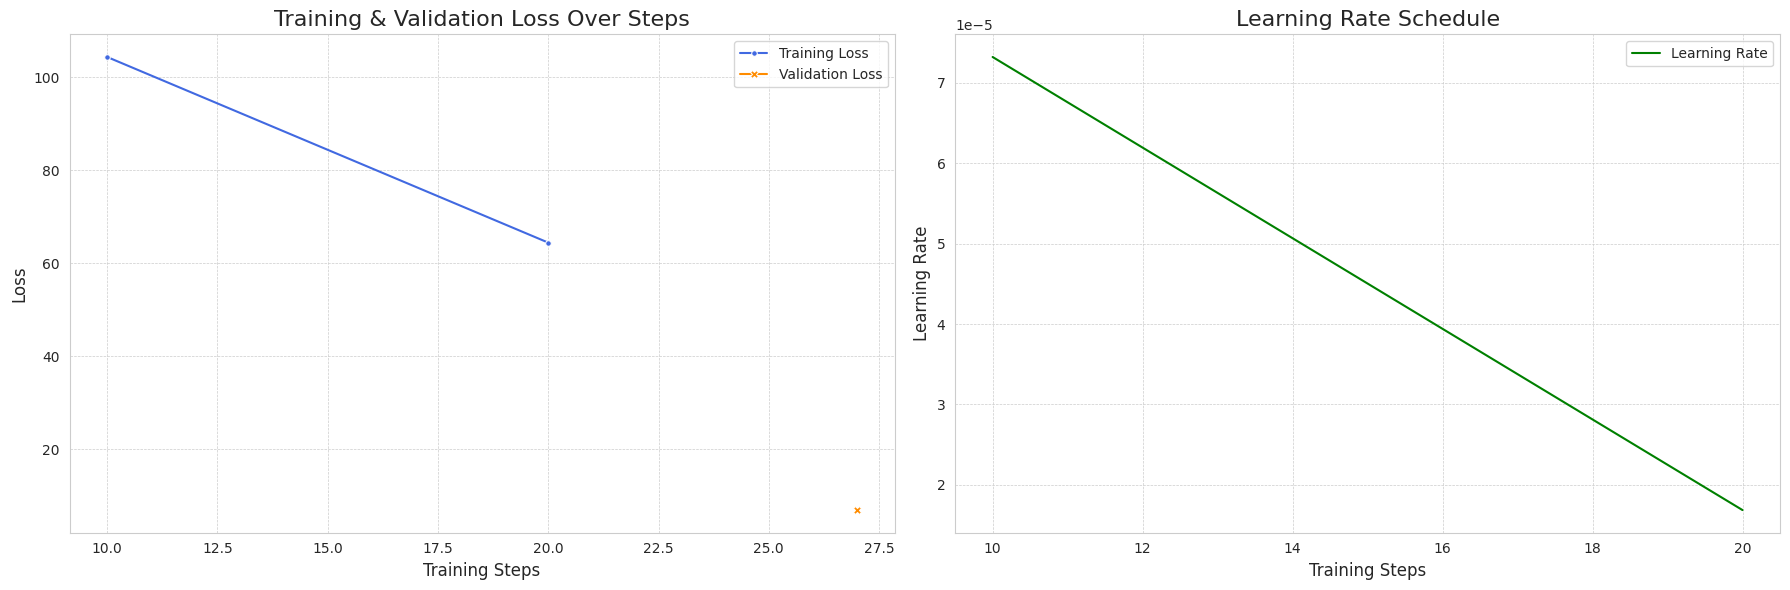


Cleaned up model and trainer from GPU memory.


In [ ]:
# Cell 9: Trainer Setup, Execution & Visualization

# Assuming all necessary variables from previous cells are defined:
# model, processed_train_dataset, processed_eval_dataset, tokenizer,
# all configuration variables (e.g., NUM_TRAIN_EPOCHS, LEARNING_RATE),
# and all path variables (e.g., OUTPUT_DIR_TRAINER_LOGS, LORA_ADAPTER_DIR).

import gc
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer

# MultiTaskDataCollator should be defined from Cell 7

if 'model' in locals() and model and \
   'processed_train_dataset' in locals() and processed_train_dataset and len(processed_train_dataset) > 0 and \
   'tokenizer' in locals() and tokenizer:

    print("\n--- Configuring and Starting Multi-Task Training ---")

    # Determine label names for the Trainer.
    # "labels" is for the LM task. "label_*" are for classification heads.
    label_names_for_trainer = ["labels"] # For Causal LM loss
    if processed_train_dataset.column_names:
        for col_name in processed_train_dataset.column_names:
            if col_name.startswith("label_"):
                label_names_for_trainer.append(col_name)

    label_names_for_trainer = sorted(list(set(label_names_for_trainer)))
    print(f"Label names for Trainer: {label_names_for_trainer}")

    # --- TWEAKED TrainingArguments ---
    # We now enable load_best_model_at_end for better generalization
    training_args_dict = {
        "output_dir": OUTPUT_DIR_TRAINER_LOGS,
        "num_train_epochs": NUM_TRAIN_EPOCHS,
        "per_device_train_batch_size": PER_DEVICE_TRAIN_BATCH_SIZE,
        "gradient_accumulation_steps": GRADIENT_ACCUMULATION_STEPS,
        "optim": OPTIM,
        "save_strategy": SAVE_STRATEGY,
        "logging_steps": LOGGING_STEPS,
        "learning_rate": LEARNING_RATE,
        "weight_decay": WEIGHT_DECAY,
        "max_grad_norm": MAX_GRAD_NORM,
        "warmup_ratio": WARMUP_RATIO,
        "lr_scheduler_type": LR_SCHEDULER_TYPE,
        "report_to": "tensorboard",
        "eval_strategy": "epoch" if processed_eval_dataset and len(processed_eval_dataset) > 0 else "no",
        "per_device_eval_batch_size": PER_DEVICE_EVAL_BATCH_SIZE,
        "gradient_checkpointing": GRADIENT_CHECKPOINTING,
        "remove_unused_columns": False, # Important: we need to keep all label columns for the custom model
        "label_names": label_names_for_trainer, # Explicitly tell Trainer which columns are labels
        "seed": SEED,
        # -- MODIFICATION FOR GENERALIZATION --
        "load_best_model_at_end": True if "epoch" in SAVE_STRATEGY or "steps" in SAVE_STRATEGY else False,
        "metric_for_best_model": "eval_loss", # Use eval loss to find the best model
        "save_total_limit": 2, # Save the best and the last checkpoint
    }

    if GRADIENT_CHECKPOINTING:
        training_args_dict["gradient_checkpointing_kwargs"] = GC_KWARGS

    if USE_4BIT_QUANTIZATION:
        training_args_dict["bf16"] = (BNB_4BIT_COMPUTE_DTYPE == torch.bfloat16)
        training_args_dict["fp16"] = (BNB_4BIT_COMPUTE_DTYPE == torch.float16)
    else:
        if DEVICE.type == 'cuda':
            runtime_bf16_supported = torch.cuda.is_bf16_supported()
            training_args_dict["bf16"] = runtime_bf16_supported
            training_args_dict["fp16"] = not runtime_bf16_supported
            print(f"Non-quantized training will use {'BF16' if runtime_bf16_supported else 'FP16'}.")

    training_args = TrainingArguments(**training_args_dict)

    collator = MultiTaskDataCollator(tokenizer=tokenizer, mlm=False, max_length=MAX_SEQ_LENGTH_TRAINING)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=processed_train_dataset,
        eval_dataset=processed_eval_dataset,
        tokenizer=tokenizer,
        data_collator=collator,
    )

    print("Trainer instantiated. Starting training...")
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

    train_result = None
    try:
        print("Starting trainer.train()...")
        train_result = trainer.train()
        print("Training finished.")

        trainer.log_metrics("train", train_result.metrics)
        trainer.save_metrics("train", train_result.metrics)
        print("Training metrics saved.")

        # Since load_best_model_at_end=True, trainer.save_model() will save the best model.
        # The underlying peft model's save_pretrained is called by trainer.save_model().
        trainer.save_model(LORA_ADAPTER_DIR)
        print(f"Best LoRA adapter saved to {LORA_ADAPTER_DIR}")

        # Manually save the classification heads from the best model
        print(f"Saving classification head weights to {CLASSIFICATION_HEADS_PATH}...")
        resolver_instance = trainer.model.base_model
        head_state_dict_to_save = {}
        for head_name in num_labels_dict_global.keys():
            head_attr = f"head_{head_name}"
            if hasattr(resolver_instance, head_attr):
                head_module = getattr(resolver_instance, head_attr)
                for param_name, param_value in head_module.state_dict().items():
                    head_state_dict_to_save[f"{head_attr}.{param_name}"] = param_value.cpu()

        if head_state_dict_to_save:
            torch.save(head_state_dict_to_save, CLASSIFICATION_HEADS_PATH)
            print("Classification head weights saved.")
        else:
            print("Warning: No classification head weights found to save.")

        print(f"Saving Tokenizer to {TOKENIZER_SAVE_PATH}...")
        tokenizer.save_pretrained(TOKENIZER_SAVE_PATH)
        print("Tokenizer saved.")
        print(f"\nAll artifacts for the best model are saved in {FINE_TUNED_MODEL_DIR}")

    except Exception as e:
        print(f"Error during training or saving: {e}")
        import traceback
        traceback.print_exc()

    # --- NEW: VISUALIZATION BLOCK ---
    if train_result and trainer.state.log_history:
        print("\n--- Generating Training Visualizations ---")
        try:
            log_df = pd.DataFrame(trainer.state.log_history)

            # Separate logs
            train_logs = log_df[log_df['loss'].notna()].copy()
            eval_logs = log_df[log_df['eval_loss'].notna()].copy()
            lr_logs = log_df[log_df['learning_rate'].notna()].copy()

            sns.set_style("whitegrid")
            plt.figure(figsize=(18, 6))

            # Plot 1: Training and Validation Loss
            ax1 = plt.subplot(1, 2, 1)
            if not train_logs.empty:
                sns.lineplot(data=train_logs, x='step', y='loss', label='Training Loss', ax=ax1, color='royalblue', marker='o', markersize=4)
            if not eval_logs.empty:
                sns.lineplot(data=eval_logs, x='step', y='eval_loss', label='Validation Loss', ax=ax1, color='darkorange', marker='X', markersize=6)
            ax1.set_title('Training & Validation Loss Over Steps', fontsize=16)
            ax1.set_xlabel('Training Steps', fontsize=12)
            ax1.set_ylabel('Loss', fontsize=12)
            ax1.legend()
            ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

            # Plot 2: Learning Rate Schedule
            ax2 = plt.subplot(1, 2, 2)
            if not lr_logs.empty:
                sns.lineplot(data=lr_logs, x='step', y='learning_rate', label='Learning Rate', ax=ax2, color='green')
            ax2.set_title('Learning Rate Schedule', fontsize=16)
            ax2.set_xlabel('Training Steps', fontsize=12)
            ax2.set_ylabel('Learning Rate', fontsize=12)
            ax2.legend()
            ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

            plt.tight_layout()

            # Save the figure
            plot_save_path = os.path.join(EVAL_RESULTS_DIR, "training_graphs.png")
            plt.savefig(plot_save_path, dpi=300)
            print(f"Training graphs saved to: {plot_save_path}")

            # Display the plots in the notebook
            plt.show()

        except Exception as e:
            print(f"Could not generate plots. Error: {e}")
            print("Log history from trainer state:")
            print(trainer.state.log_history)

    # --- END OF VISUALIZATION BLOCK ---

    # Final cleanup
    if 'model' in locals() and hasattr(model, 'device') and model.device.type == 'cuda':
        del model, trainer
        if 'model_multitask' in locals(): del model_multitask
        gc.collect()
        torch.cuda.empty_cache()
        print("\nCleaned up model and trainer from GPU memory.")

else:
    print("Training skipped: missing model, processed training data, or tokenizer.")

loading file tokenizer.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file chat_template.jinja


--- 1. Setting up for Evaluation ---
Evaluation tasks: ['is_actionable', 'complaint_category', 'decision_recommendation', 'info_complete', 'tone', 'refund_percentage', 'sentiment', 'aggression']
Final model will be pushed to: https://huggingface.co/ShovalBenjer/gemma-3-4b-fashion-multitask_A4000_v1


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/config.json
text_config is None, using default Gemma3TextConfig vision config.
vision_config is None or incompatible with Gemma3VisionConfig intialization. Gemma3 will be limited to text tasks.
Model config Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "boi_token_index": 255999,
  "eoi_token_index": 256000,
  "eos_token_id": [
    1,
    106
  ],
  "image_token_index": 262144,
  "initializer_range": 0.02,
  "mm_tokens_per_image": 256,
  "model_type": "gemma3",
  "text_config": {
    "attention_bias": false,
    "attention_dropout": 0.0,
    "attn_logit_softcapping": null,
    "cache_implementation": "hybrid",
    "final_logit_softcapping": null,
    "head_dim": 256,
    "hidden_activation": "gelu_pytorch_tanh",
    "hidden_size": 2560,
    "initializer_range": 0.02,
    "intermediate_size": 1


--- 1. Evaluating Fine-Tuned Model ---
Loading fine-tuned model...
GCR: QLoRA enabled. Using device_map='auto' and compute_dtype=torch.bfloat16


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Instantiating Gemma3ForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "pad_token_id": 0
}

target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/gemma-3-4b-it were not used when initializing Gemma3ForCausalLM: ['multi_modal_projector.mm_input_projection_weight', 'multi_modal_projector.mm_soft_emb_norm.weight', 'vision_tower.vision_model.embeddings.patch_embedding.bias', 'vision_tower.vision_model.embeddings.patch_embedding.weight', 'vision_tower.vision_model.embeddings.position_embedding.weight', 'vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_tower.vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_tower.vision_model.encod

GCR: Base model loaded. Hidden_size: 2560
Loading trained classification heads from: /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/classification_heads.pth
Applying LoRA adapter from: /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/lora_adapter
Model loaded, cast to torch.bfloat16, and moved to cuda:0.


Predicting with LoraModel:   0%|          | 0/24 [00:00<?, ?it/s]


--- Releasing GPU memory for the base model ---


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/config.json
text_config is None, using default Gemma3TextConfig vision config.
vision_config is None or incompatible with Gemma3VisionConfig intialization. Gemma3 will be limited to text tasks.
Model config Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "boi_token_index": 255999,
  "eoi_token_index": 256000,
  "eos_token_id": [
    1,
    106
  ],
  "image_token_index": 262144,
  "initializer_range": 0.02,
  "mm_tokens_per_image": 256,
  "model_type": "gemma3",
  "text_config": {
    "attention_bias": false,
    "attention_dropout": 0.0,
    "attn_logit_softcapping": null,
    "cache_implementation": "hybrid",
    "final_logit_softcapping": null,
    "head_dim": 256,
    "hidden_activation": "gelu_pytorch_tanh",
    "hidden_size": 2560,
    "initializer_range": 0.02,
    "intermediate_size": 1


--- 2. Evaluating Base Model ---
Loading base model...
GCR: QLoRA enabled. Using device_map='auto' and compute_dtype=torch.bfloat16


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Instantiating Gemma3ForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "pad_token_id": 0
}

target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/gemma-3-4b-it were not used when initializing Gemma3ForCausalLM: ['multi_modal_projector.mm_input_projection_weight', 'multi_modal_projector.mm_soft_emb_norm.weight', 'vision_tower.vision_model.embeddings.patch_embedding.bias', 'vision_tower.vision_model.embeddings.patch_embedding.weight', 'vision_tower.vision_model.embeddings.position_embedding.weight', 'vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_tower.vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_tower.vision_model.encod

GCR: Base model loaded. Hidden_size: 2560
Model loaded, cast to torch.bfloat16, and moved to cuda:0.


Predicting with Gemma3ForCausalLM:   0%|          | 0/24 [00:00<?, ?it/s]


--- Releasing GPU memory after evaluation ---

--- 3. Calculating Performance Metrics ---

--- Comparative Metrics ---
                        Fine-Tuned Model                               Base Model (Untrained Heads)                              
                                Accuracy Precision    Recall  F1-Score                     Accuracy Precision    Recall  F1-Score
is_actionable                   1.000000  1.000000  1.000000  1.000000                     0.000000  0.000000  0.000000  0.000000
complaint_category              0.541667  0.439583  0.541667  0.440653                     0.375000  0.140625  0.375000  0.204545
decision_recommendation         0.708333  0.501736  0.708333  0.587398                     0.000000  0.000000  0.000000  0.000000
info_complete                   0.875000  0.765625  0.875000  0.816667                     0.833333  0.760870  0.833333  0.795455
refund_percentage               0.875000  0.765625  0.875000  0.816667                     0.000000 

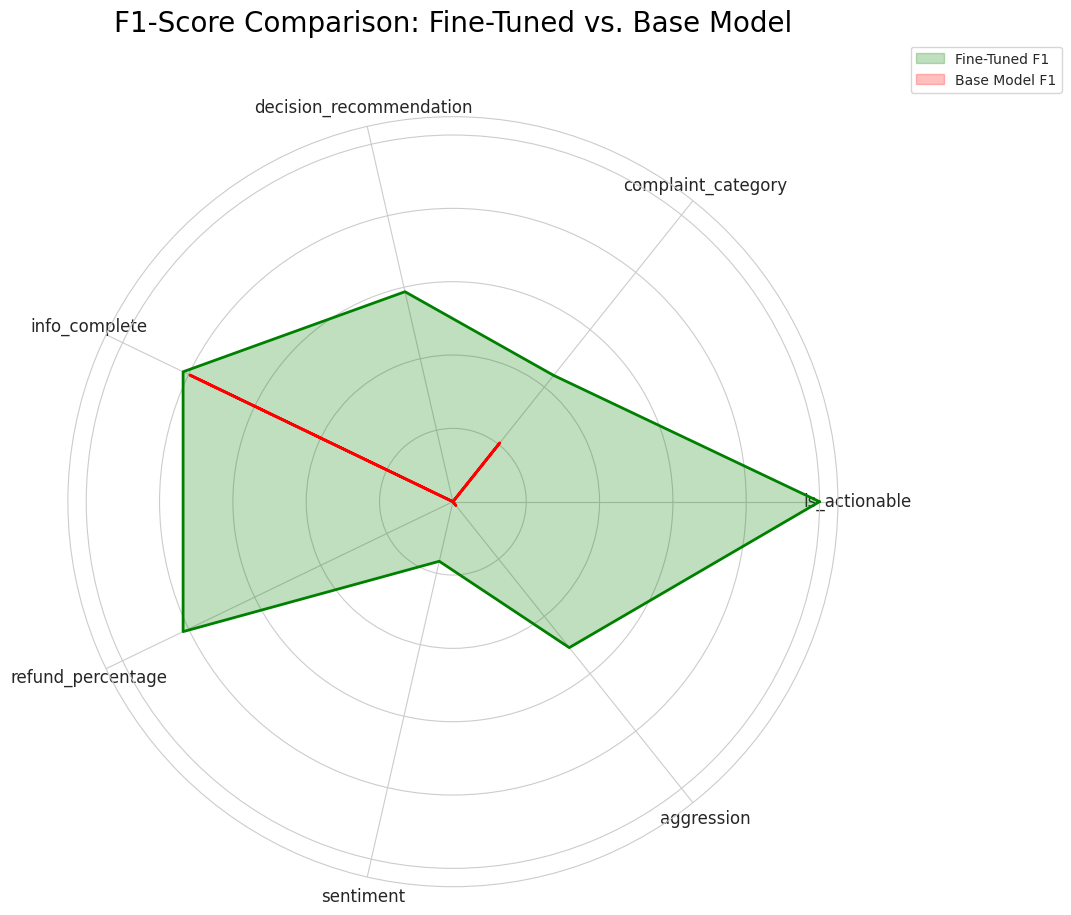

Radar chart saved to /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/evaluation_results/f1_score_radar_chart.png


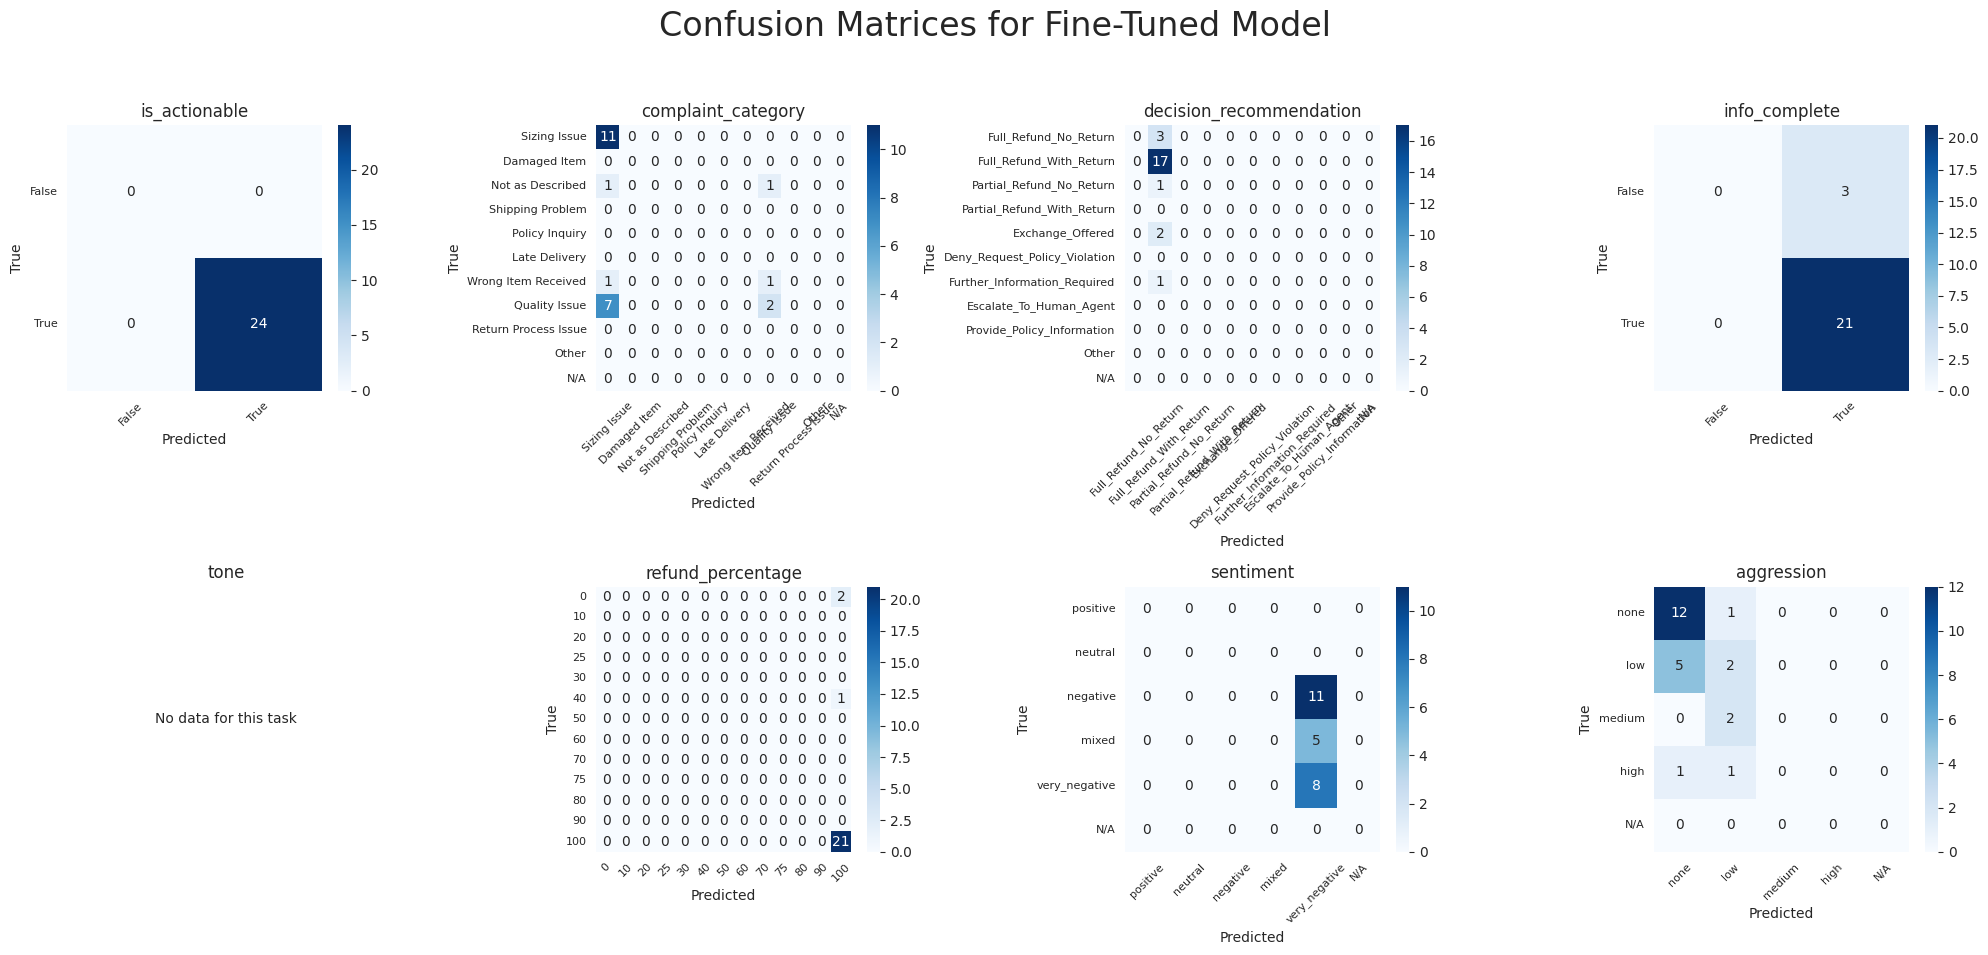

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-3-4b-it/snapshots/093f9f388b31de276ce2de164bdc2081324b9767/config.json
text_config is None, using default Gemma3TextConfig vision config.
vision_config is None or incompatible with Gemma3VisionConfig intialization. Gemma3 will be limited to text tasks.
Model config Gemma3Config {
  "architectures": [
    "Gemma3ForConditionalGeneration"
  ],
  "boi_token_index": 255999,
  "eoi_token_index": 256000,
  "eos_token_id": [
    1,
    106
  ],
  "image_token_index": 262144,
  "initializer_range": 0.02,
  "mm_tokens_per_image": 256,
  "model_type": "gemma3",
  "text_config": {
    "attention_bias": false,
    "attention_dropout": 0.0,
    "attn_logit_softcapping": null,
    "cache_implementation": "hybrid",
    "final_logit_softcapping": null,
    "head_dim": 256,
    "hidden_activation": "gelu_pytorch_tanh",
    "hidden_size": 2560,
    "initializer_range": 0.02,
    "intermediate_size": 1

Confusion matrices saved to /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/evaluation_results/confusion_matrices.png

--- 5. Pushing Model to Hub: ShovalBenjer/gemma-3-4b-fashion-multitask_A4000_v1 ---
Re-loading fine-tuned model for pushing to Hub...
Loading fine-tuned model...
GCR: QLoRA enabled. Using device_map='auto' and compute_dtype=torch.bfloat16


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Instantiating Gemma3ForCausalLM model under default dtype torch.float16.
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": 1,
  "pad_token_id": 0
}

target_dtype {target_dtype} is replaced by `CustomDtype.INT4` for 4-bit BnB quantization


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at google/gemma-3-4b-it were not used when initializing Gemma3ForCausalLM: ['multi_modal_projector.mm_input_projection_weight', 'multi_modal_projector.mm_soft_emb_norm.weight', 'vision_tower.vision_model.embeddings.patch_embedding.bias', 'vision_tower.vision_model.embeddings.patch_embedding.weight', 'vision_tower.vision_model.embeddings.position_embedding.weight', 'vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'vision_tower.vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias', 'vision_tower.vision_model.encod

GCR: Base model loaded. Hidden_size: 2560
Loading trained classification heads from: /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/classification_heads.pth
Applying LoRA adapter from: /notebooks/gemma-3-4b-fashion-multitask_A4000_v1/lora_adapter
Model loaded, cast to torch.bfloat16, and moved to cuda:0.


Uploading the following files to ShovalBenjer/gemma-3-4b-fashion-multitask_A4000_v1: README.md,adapter_config.json,adapter_model.safetensors


adapter_model.safetensors:   0%|          | 0.00/59.7M [00:00<?, ?B/s]

LoRA adapter pushed successfully.


classification_heads.pth:   0%|          | 0.00/590k [00:00<?, ?B/s]

Classification heads pushed successfully.


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer config file saved in gemma-3-4b-fashion-multitask_A4000_v1/tokenizer_config.json
Special tokens file saved in gemma-3-4b-fashion-multitask_A4000_v1/special_tokens_map.json
Uploading the following files to ShovalBenjer/gemma-3-4b-fashion-multitask_A4000_v1: tokenizer.model,README.md,tokenizer.json,added_tokens.json,tokenizer_config.json,special_tokens_map.json


tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

Tokenizer pushed successfully.

✅ Successfully pushed all artifacts to: https://huggingface.co/ShovalBenjer/gemma-3-4b-fashion-multitask_A4000_v1
Final model cleaned from memory.

Evaluation and deployment process complete.


In [ ]:
# Cell 10: Full Evaluation & Visualization

# --- 1. Imports and Setup ---
print("--- 1. Setting up for Evaluation ---")
import torch, gc, os, json, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, traceback
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from huggingface_hub import HfApi, HfFolder, create_repo, upload_file
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from peft import PeftModel

# Defensive checks
if 'GemmaComplaintResolver' not in locals():
    raise NameError("The 'GemmaComplaintResolver' class is not defined. Please ensure Cell 5 has been run.")
if 'processed_eval_dataset' not in locals() or processed_eval_dataset is None:
     raise NameError("The 'processed_eval_dataset' is not defined. Please ensure Cell 6 has been run successfully.")

# --- FIX: Define the missing TASK_TO_LABELS_MAP dictionary ---
# This dictionary maps task names to their respective human-readable label lists for plotting.
# All these list variables (e.g., COMPLAINT_CATEGORIES) are defined globally in Cell 4.
TASK_TO_LABELS_MAP = {
    "is_actionable": ["False", "True"],
    "complaint_category": COMPLAINT_CATEGORIES,
    "decision_recommendation": DECISION_TYPES,
    "info_complete": ["False", "True"],
    "tone": EMOTIONAL_TONES_FOR_FORMAL_ANSWER,
    "refund_percentage": [str(p) for p in SUGGESTED_REFUND_PERCENTAGE_VALUES],
    "sentiment": SENTIMENT_CATEGORIES,
    "aggression": AGGRESSION_LEVELS
}

# --- Helper Functions for Evaluation (with minor robustness improvement) ---
def load_inference_model(is_finetuned: bool):
    """Loads a model for inference, handling quantization and applying the dtype fix for custom heads."""
    print(f"Loading {'fine-tuned' if is_finetuned else 'base'} model...")
    model_config = AutoConfig.from_pretrained(STUDENT_MODEL_ID, trust_remote_code=True)

    # Instantiate our custom model class
    inference_model = GemmaComplaintResolver(
        base_model_name_or_path=STUDENT_MODEL_ID,
        num_labels_dict=num_labels_dict_global,
        model_config_for_base_loading=model_config,
    )

    if is_finetuned:
        if not os.path.exists(CLASSIFICATION_HEADS_PATH):
            raise FileNotFoundError(f"Fine-tuned evaluation requires classification heads at {CLASSIFICATION_HEADS_PATH}")
        print(f"Loading trained classification heads from: {CLASSIFICATION_HEADS_PATH}")
        head_weights = torch.load(CLASSIFICATION_HEADS_PATH, map_location='cpu')
        inference_model.load_state_dict(head_weights, strict=False)
        print(f"Applying LoRA adapter from: {LORA_ADAPTER_DIR}")
        inference_model = PeftModel.from_pretrained(inference_model, LORA_ADAPTER_DIR)

    # DTYPE FIX: Cast the entire model to the correct compute dtype AFTER all components are loaded.
    compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
    inference_model.to(dtype=compute_dtype, device=DEVICE)

    inference_model.eval()
    print(f"Model loaded, cast to {compute_dtype}, and moved to {inference_model.device}.")
    return inference_model

@torch.no_grad()
def get_all_predictions(model, dataset, tokenizer):
    """Generates predictions for all tasks for a given model."""
    predictions = {task: [] for task in TASKS}
    ground_truths = {task: [] for task in TASKS}
    model_name = type(model.base_model).__name__ if hasattr(model, 'base_model') else type(model).__name__

    required_col = 'text_for_lm'
    if required_col not in dataset.column_names:
        raise KeyError(f"The required column '{required_col}' was not found. Available columns: {dataset.column_names}")

    for example in tqdm(dataset, desc=f"Predicting with {model_name}"):
        input_text = example[required_col]
        inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=MAX_SEQ_LENGTH_TRAINING).to(DEVICE)
        outputs = model(**inputs)
        for task in TASKS:
            logits = outputs[f"logits_{task}"]
            pred = torch.argmax(logits, dim=-1).cpu().item()
            true_label = example[f"label_{task}"]
            if true_label != -100:
                predictions[task].append(pred)
                ground_truths[task].append(true_label)
    return predictions, ground_truths

# --- Main Sequential Evaluation Logic ---
TASKS = list(num_labels_dict_global.keys())
print(f"Evaluation tasks: {TASKS}")
new_model_repo_id = f"{HfApi().whoami()['name']}/{os.path.basename(FINE_TUNED_MODEL_DIR)}"
print(f"Final model will be pushed to: https://huggingface.co/{new_model_repo_id}")

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_SAVE_PATH)

# --- Step 1: Evaluate Fine-Tuned Model ---
print("\n--- 1. Evaluating Fine-Tuned Model ---")
finetuned_model = load_inference_model(is_finetuned=True)
finetuned_preds, finetuned_trues = get_all_predictions(finetuned_model, processed_eval_dataset, tokenizer)
print("\n--- Releasing GPU memory for the base model ---")
del finetuned_model
gc.collect()
torch.cuda.empty_cache()

# --- Step 2: Evaluate Base Model ---
print("\n--- 2. Evaluating Base Model ---")
base_model_for_eval = load_inference_model(is_finetuned=False)
base_preds, base_trues = get_all_predictions(base_model_for_eval, processed_eval_dataset, tokenizer)
print("\n--- Releasing GPU memory after evaluation ---")
del base_model_for_eval
gc.collect()
torch.cuda.empty_cache()

# --- 3. Metrics Calculation ---
print("\n--- 3. Calculating Performance Metrics ---")
def calculate_metrics(predictions, truths):
    results = {}
    for task in TASKS:
        if not truths.get(task): continue
        precision, recall, f1, _ = precision_recall_fscore_support(truths[task], predictions[task], average='weighted', zero_division=0)
        accuracy = accuracy_score(truths[task], predictions[task])
        results[task] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1}
    return results

finetuned_metrics = calculate_metrics(finetuned_preds, finetuned_trues)
base_metrics = calculate_metrics(base_preds, base_trues)
metrics_df = pd.concat({
    "Fine-Tuned Model": pd.DataFrame(finetuned_metrics).T,
    "Base Model (Untrained Heads)": pd.DataFrame(base_metrics).T
}, axis=1)
print("\n--- Comparative Metrics ---")
print(metrics_df.to_string())
# Save metrics to a file
metrics_df.to_csv(os.path.join(EVAL_RESULTS_DIR, "comparative_metrics.csv"))
print(f"\nMetrics saved to {os.path.join(EVAL_RESULTS_DIR, 'comparative_metrics.csv')}")

# --- 4. Visualization ---
print("\n--- 4. Generating Visualizations ---")

# A. Radar Chart for F1-Score Comparison
if finetuned_metrics:
    labels = list(finetuned_metrics.keys())
    finetuned_f1 = [finetuned_metrics[task]['F1-Score'] for task in labels]
    base_f1 = [base_metrics.get(task, {}).get('F1-Score', 0) for task in labels]
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    finetuned_f1 += finetuned_f1[:1]
    base_f1 += base_f1[:1]
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.fill(angles, finetuned_f1, color='green', alpha=0.25, label='Fine-Tuned F1')
    ax.plot(angles, finetuned_f1, color='green', linewidth=2)
    ax.fill(angles, base_f1, color='red', alpha=0.25, label='Base Model F1')
    ax.plot(angles, base_f1, color='red', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=12)
    plt.title('F1-Score Comparison: Fine-Tuned vs. Base Model', size=20, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    radar_chart_path = os.path.join(EVAL_RESULTS_DIR, "f1_score_radar_chart.png")
    plt.savefig(radar_chart_path, bbox_inches='tight')
    plt.show()
    print(f"Radar chart saved to {radar_chart_path}")

# B. Confusion Matrices for the Fine-Tuned Model
if finetuned_metrics:
    num_tasks = len(TASKS)
    fig, axes = plt.subplots(2, (num_tasks + 1) // 2, figsize=(20, 10))
    axes = axes.flatten()
    fig.suptitle('Confusion Matrices for Fine-Tuned Model', fontsize=24)
    for i, task in enumerate(TASKS):
        if not finetuned_trues[task]:
            axes[i].text(0.5, 0.5, 'No data for this task', ha='center', va='center')
            axes[i].set_title(task)
            axes[i].axis('off')
            continue
        # Use the newly defined map to get the correct labels
        class_labels = TASK_TO_LABELS_MAP.get(task, [])
        cm = confusion_matrix(finetuned_trues[task], finetuned_preds[task], labels=range(len(class_labels)))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], xticklabels=class_labels, yticklabels=class_labels)
        axes[i].set_title(task)
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)
    for j in range(i + 1, len(axes)): axes[j].axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    cm_path = os.path.join(EVAL_RESULTS_DIR, "confusion_matrices.png")
    plt.savefig(cm_path, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrices saved to {cm_path}")

# --- 5. Push to Hugging Face Hub ---
print(f"\n--- 5. Pushing Model to Hub: {new_model_repo_id} ---")
final_model_to_push = None
try:
    print("Re-loading fine-tuned model for pushing to Hub...")
    final_model_to_push = load_inference_model(is_finetuned=True)

    repo_url = create_repo(repo_id=new_model_repo_id, exist_ok=True, private=False) # Assuming public

    final_model_to_push.push_to_hub(new_model_repo_id)
    print("LoRA adapter pushed successfully.")

    api = HfApi()
    api.upload_file(path_or_fileobj=CLASSIFICATION_HEADS_PATH, path_in_repo="classification_heads.pth", repo_id=new_model_repo_id)
    print("Classification heads pushed successfully.")

    tokenizer.push_to_hub(new_model_repo_id)
    print("Tokenizer pushed successfully.")

    # ... (Your README creation code could go here) ...
    print(f"\n✅ Successfully pushed all artifacts to: {repo_url.url}")

except Exception as e:
    print(f"❌ An error occurred while pushing to the Hub: {e}")
    traceback.print_exc()
finally:
    if final_model_to_push is not None:
        del final_model_to_push
        gc.collect()
        torch.cuda.empty_cache()
        print("Final model cleaned from memory.")

# --- 6. Ollama Serving Instructions ---
# ... (Your Ollama instructions) ...
print("\nEvaluation and deployment process complete.")